In [15]:
import os 

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(os.path.join(os.path.abspath(''), 'plot_style.mplstyle'))
plots_dir = '../plots/'

from desilike.samples import Profiles, Chain, plotting
from emulator_fit import get_power_likelihood, get_corr_likelihood

tracer = 'ELG'
region = 'SGC'
stat = 'power'
rp_cut = 2.5

In [2]:
emulator_dir = '/global/cfs/cdirs/desi/users/mpinon/emulators/emulators_shapefit_{}'.format(tracer)
profiles_dir = '/global/cfs/cdirs/desi/users/mpinon/profiles/profiles_shapefit_{}_{{}}{}'.format(tracer, region)
chains_dir = '/global/cfs/cdirs/desi/users/mpinon/chains/chains_shapefit_{}_{{}}{}'.format(tracer, region)

In [3]:
profiles_complete = Profiles.load(os.path.join(profiles_dir.format('complete_'), '{}{}_velocileptors.npy'.format(stat, '_xinmax0.35' if stat=='power' else '')))
#profiles = Profiles.load('profiles_shapefit_{}_{}/{}_velocileptors.npy'.format(tracer, region, stat))
#profiles_fc = Profiles.load('profiles_shapefit_{}_{}/{}_velocileptors_fc.npy'.format(tracer, region, stat))
#profiles_complete_fc_rp_cut = Profiles.load(os.path.join(profiles_dir.format('complete_'), '{}_velocileptors_fc{}.npy'.format(stat, '_th{:.1f}'.format(rp_cut))))
profiles_complete_rp_cut = Profiles.load(os.path.join(profiles_dir.format('complete_'), '{}{}_velocileptors{}{}{}.npy'.format(stat, '_xinmax0.35' if stat=='power' else '', '_fc' if stat=='corr' else '', '_th{:.1f}'.format(rp_cut), '_directedges_max5000' if stat=='power' and rp_cut else '')))
#profiles_complete_rp_cut_Mpq = Profiles.load(os.path.join(profiles_dir.format('complete_'), '{}_velocileptors{}_Mpq.npy'.format(stat, '_th{:.1f}'.format(rp_cut))))
#profiles_fc_rp_cut = Profiles.load('profiles_shapefit_{}_{}/{}_velocileptors_fc{}.npy'.format(tracer, region, stat, '_th{:.1f}'.format(rp_cut)))
#profiles_fc_rp_cut = Profiles.load('profiles_shapefit_{}_{}/{}_velocileptors{}.npy'.format(tracer, region, stat, '_th{:.1f}'.format(rp_cut)))

In [4]:
print(profiles_complete.to_stats(tablefmt='latex'))
#print(profiles.to_stats(tablefmt='pretty'))
#print(profiles_fc.to_stats(tablefmt='latex'))
#print(profiles_complete_fc_rp_cut.to_stats(tablefmt='latex'))
#print(profiles_fc_rp_cut.to_stats(tablefmt='latex'))
print(profiles_complete_rp_cut.to_stats(tablefmt='latex'))

\begin{tabular}{llrr}
\hline
 chi2 / (108 - 13) = 3.29 / 95 = 0.03   & varied   &   bestfit &   error \\
\hline
 qpar                                   & True     &     0.984 &   0.02  \\
 qper                                   & True     &     1.003 &   0.016 \\
 dm                                     & True     &    -0.004 &   0.056 \\
 df                                     & True     &     1.054 &   0.055 \\
 b1                                     & True     &     0.18  &   0.045 \\
 b2                                     & True     &    -1.4   &   1.5   \\
 bs                                     & True     &     0.4   &   2.2   \\
 alpha0                                 & True     &    10     &  19     \\
 alpha2                                 & True     &    -4     &  32     \\
 alpha4                                 & True     &     3     &  18     \\
 sn0                                    & True     &    -0.017 &   0.07  \\
 sn2                                    & True     &

/global/cfs/cdirs/desi/users/adematti/perlmutter/cosmodesiconda/20221205-1.0.0/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


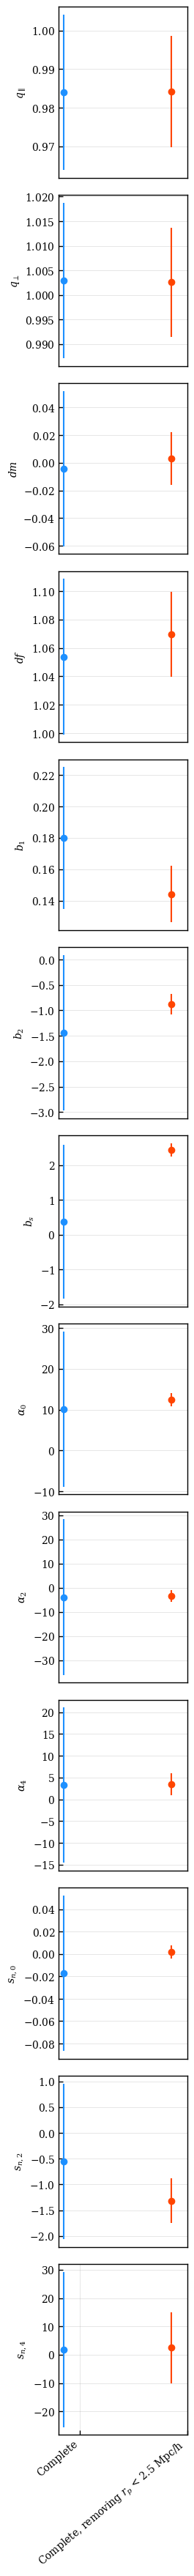

In [5]:
#plotting.plot_aligned_stacked([profiles_complete.choice()], ids=['Complete'])
plotting.plot_aligned_stacked([profiles_complete.choice(), profiles_complete_rp_cut.choice()], ids=['Complete', r'Complete, removing $r_p$ < 2.5 Mpc/h'])
#plt.savefig('{}_fit_params_{}_{}{}.pdf'.format(stat, tracer, region, '_th{:.1f}'.format(rp_cut) if rp_cut else ''), dpi=400, bbox_inches="tight")
plt.show()

In [6]:
def plot_fit(stat, completeness, fc, rp_cut, bestfit_params, labels=None, ls='-'):
    if stat=='corr':
        likelihood = get_corr_likelihood(tracer=tracer, region=region, completeness=completeness, solve=False, fc=fc, rp_cut=rp_cut, emulator_fn=os.path.join(emulator_dir.format(completeness), '{}_{{}}.npy'.format(stat)))
    if stat=='power':
        likelihood = get_power_likelihood(tracer=tracer, region=region, completeness=completeness, solve=False, fc=fc, rp_cut=rp_cut, emulator_fn=os.path.join(emulator_dir.format(completeness), '{}_xinmax0.35_{{}}.npy'.format(stat)))
        
    likelihood.solved_default = '.best'
    obs = likelihood.observables[0]
    
    height_ratios = [max(len(obs.ells), 3)] + [1] * len(obs.ells)
    figsize = (6, 1. * sum(height_ratios))
    fig, lax = plt.subplots(len(height_ratios), sharex=True, sharey=False, gridspec_kw={'height_ratios': height_ratios}, figsize=figsize, squeeze=True)
    fig.subplots_adjust(hspace=0)
    data, std = obs.data, obs.std
    
    models = []
    for bfp in bestfit_params:
        profile = globals()['profiles_' + bfp]
        print(profile.bestfit.choice(input=True), likelihood.varied_params)
        likelihood(**profile.bestfit.choice(input=True))
        models.append(obs.theory)
    
    if stat=='corr':
        for ill, ell in enumerate(obs.ells):
            lax[0].errorbar(obs.s[ill], obs.s[ill]**2 * data[ill], yerr=obs.s[ill]**2 * std[ill], color='C{:d}'.format(ill), linestyle='none', marker='o', label=r'$\ell = {:d}$'.format(ell))
        for ill, ell in enumerate(obs.ells):
            for i, m in enumerate(models):
                lax[0].plot(obs.s[ill], obs.s[ill]**2 * m[ill], color='C{:d}'.format(ill), label=labels[i] if (ill==0 and labels is not None) else None, ls=ls[i])
            for i, m in enumerate(models):
                lax[ill + 1].plot(obs.s[ill], (data[ill] - m[ill]) / std[ill], color='C{:d}'.format(ill), ls=ls[i])
            lax[ill + 1].set_ylim(-4, 4)
            for offset in [-2., 2.]: lax[ill + 1].axhline(offset, color='k', linestyle='--')
            lax[ill + 1].set_ylabel(r'$\Delta \xi_{{{0:d}}} / \sigma_{{ \xi_{{{0:d}}} }}$'.format(ell))
        lax[0].legend()
        lax[0].set_ylabel(r'$s^{2} \xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
        lax[-1].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
        
    if stat=='power':
        scaling = 'kpk'
        k_exp = 1 if scaling == 'kpk' else 0
        for ill, ell in enumerate(obs.ells):
            lax[0].errorbar(obs.k[ill], obs.k[ill]**k_exp * data[ill], yerr=obs.k[ill]**k_exp * std[ill], color='C{:d}'.format(ill), linestyle='none', marker='o', label=r'$\ell = {:d}$'.format(ell))
            for i, m in enumerate(models):
                lax[0].plot(obs.k[ill], obs.k[ill]**k_exp * m[ill], color='C{:d}'.format(ill), label=labels[i] if (ill==0 and labels is not None) else None, ls=ls[i])
        for ill, ell in enumerate(obs.ells):
            for i, m in enumerate(models):
                lax[ill + 1].plot(obs.k[ill], (data[ill] - m[ill]) / std[ill], color='C{:d}'.format(ill), ls=ls[i])
            lax[ill + 1].set_ylim(-4, 4)
            for offset in [-2., 2.]: lax[ill + 1].axhline(offset, color='k', linestyle='--')
            lax[ill + 1].set_ylabel(r'$\Delta P_{{{0:d}}} / \sigma_{{ P_{{{0:d}}} }}$'.format(ell))
        for ax in lax: ax.grid(True)
        lax[0].legend()
        if scaling == 'kpk':
            lax[0].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
        if scaling == 'loglog':
            lax[0].set_ylabel(r'$P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
            lax[0].set_yscale('log')
            lax[0].set_xscale('log')
        lax[-1].set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')

footprint


/global/cfs/cdirs/desi/users/adematti/perlmutter/cosmodesiconda/20221205-1.0.0/conda/lib/python3.10/site-packages/numpy/lib/polynomial.py:1337: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


{'qpar': 0.9839784976952828, 'qper': 1.0029286221051554, 'dm': -0.00421517671807725, 'df': 1.0538705168486961, 'b1': 0.17998089444042434, 'b2': -1.442161599799439, 'bs': 0.37567750647132914, 'alpha0': 10.146639110206282, 'alpha2': -3.8925692539510015, 'alpha4': 3.242502176815439, 'sn0': -0.017165714751568577, 'sn2': -0.5521584020039885, 'sn4': 1.8663462357850065} ParameterCollection(['qpar', 'qper', 'dm', 'df', 'b1', 'b2', 'bs', 'alpha0', 'alpha2', 'alpha4', 'sn0', 'sn2', 'sn4'])


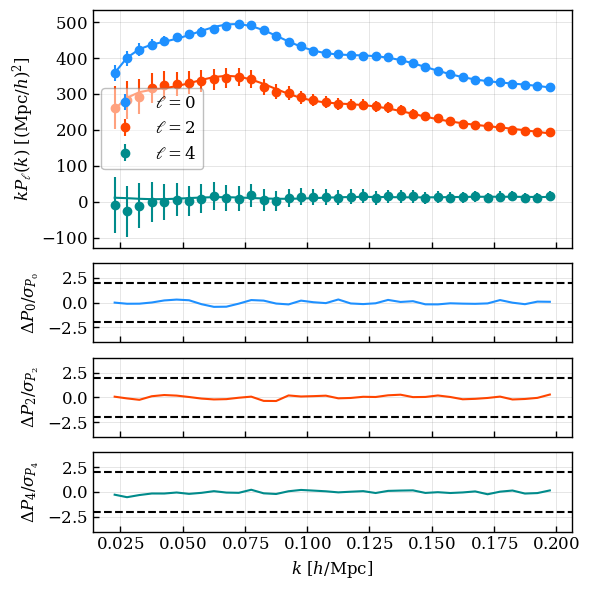

In [9]:
completeness = 'complete_'
plot_fit(stat, completeness, '', 0, ['complete'])
plt.savefig(os.path.join(plots_dir, '{}_fit_{}_{}{}.pdf'.format(stat, tracer, completeness, region)), dpi=200)
plt.show()

footprint


/global/cfs/cdirs/desi/users/adematti/perlmutter/cosmodesiconda/20221205-1.0.0/conda/lib/python3.10/site-packages/numpy/lib/polynomial.py:1337: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


{'qpar': 0.9839784976952828, 'qper': 1.0029286221051554, 'dm': -0.00421517671807725, 'df': 1.0538705168486961, 'b1': 0.17998089444042434, 'b2': -1.442161599799439, 'bs': 0.37567750647132914, 'alpha0': 10.146639110206282, 'alpha2': -3.8925692539510015, 'alpha4': 3.242502176815439, 'sn0': -0.017165714751568577, 'sn2': -0.5521584020039885, 'sn4': 1.8663462357850065} ParameterCollection(['qpar', 'qper', 'dm', 'df', 'b1', 'b2', 'bs', 'alpha0', 'alpha2', 'alpha4', 'sn0', 'sn2', 'sn4'])
{'qpar': 0.9842113864257847, 'qper': 1.0026107800495172, 'dm': 0.002977387500694797, 'df': 1.0696692294679309, 'b1': 0.1442594856284327, 'b2': -0.8770872624094609, 'bs': 2.4394934119740292, 'alpha0': 12.438729580210884, 'alpha2': -3.4450227475003063, 'alpha4': 3.45047859651509, 'sn0': 0.0017152402095359984, 'sn2': -1.3194719086987068, 'sn4': 2.4957082164132305} ParameterCollection(['qpar', 'qper', 'dm', 'df', 'b1', 'b2', 'bs', 'alpha0', 'alpha2', 'alpha4', 'sn0', 'sn2', 'sn4'])


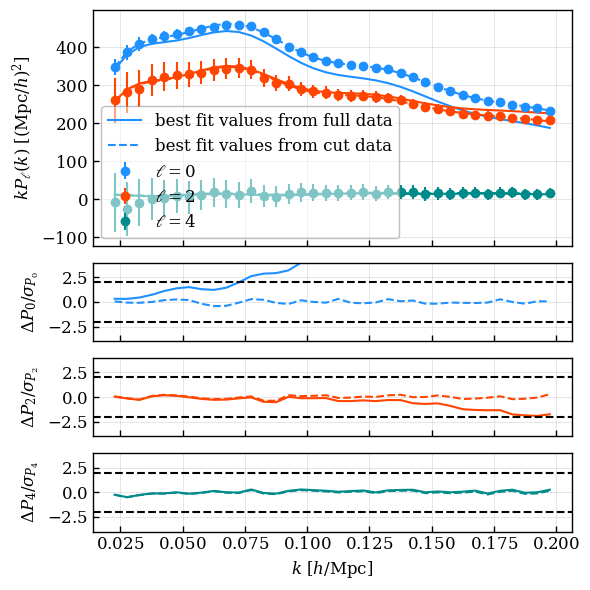

In [10]:
completeness = 'complete_'
plot_fit(stat, completeness, '', 2.5, ['complete', 'complete{}_rp_cut'.format('')], ls=['-', '--'], labels=['best fit values from full data', 'best fit values from cut data'])
plt.savefig(os.path.join(plots_dir, '{}{}_fit_{}_{}{}{}{}.pdf'.format(stat, '_xinmax0.35' if stat=='power' else '', tracer, completeness, region, '', '_th{:.1f}'.format(rp_cut), '_directedges_max5000' if stat=='power' and rp_cut else '')), dpi=200)
plt.show()

In [11]:
#likelihood.observables[0].plot_covariance_matrix()

In [12]:
#plotting.plot_aligned_stacked(profiles_complete)

In [18]:
from getdist import plots
g = plots.get_single_plotter(width_inch=10, scaling=False, ratio=1)
g.settings.axes_fontsize = 12
g.settings.axes_labelsize = 12

<Figure size 600x600 with 0 Axes>

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


/tmp/ipykernel_107141/1409588712.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(plots_dir, 'corner_plot_{}_{}_{}_th{:.1f}_spotlight.png'.format(tracer, region, stat, rp_cut)), dpi=300)
/global/cfs/cdirs/desi/users/adematti/perlmutter/cosmodesiconda/20221205-1.0.0/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


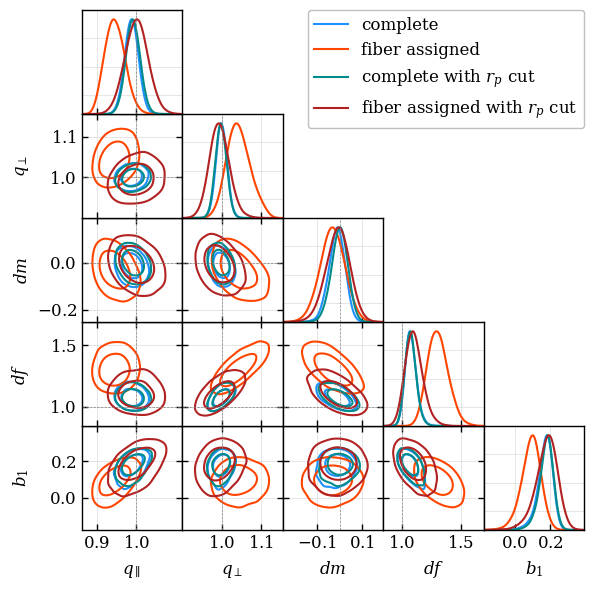

In [19]:
if stat=='power':
    chain_complete = Chain.concatenate([Chain.load(os.path.join(chains_dir.format('complete_'), 'power_velocileptors_{:d}.npy'.format(i))).remove_burnin(0.5)[::10] for i in range(8)])
    chain = Chain.concatenate([Chain.load(os.path.join(chains_dir.format(''), 'power_velocileptors_{:d}.npy'.format(i))).remove_burnin(0.5)[::10] for i in range(8)])
    chain_complete_rp_cut = Chain.concatenate([Chain.load(os.path.join(chains_dir.format('complete_'), 'power_velocileptors_th{:.1f}_{:d}.npy'.format(rp_cut, i))).remove_burnin(0.5)[::10] for i in range(8)])
    chain_rp_cut = Chain.concatenate([Chain.load(os.path.join(chains_dir.format(''), 'power_velocileptors_th{:.1f}_{:d}.npy'.format(rp_cut, i))).remove_burnin(0.5)[::10] for i in range(8)])
if stat=='corr':
    chain_complete = Chain.concatenate([Chain.load(os.path.join(chains_dir.format('complete_'), 'corr_velocileptors_{:d}.npy'.format(i))).remove_burnin(0.5)[::10] for i in range(8)])
    chain = Chain.concatenate([Chain.load(os.path.join(chains_dir.format(''), 'corr_velocileptors_{:d}.npy'.format(i))).remove_burnin(0.5)[::10] for i in range(8)])
    chain_complete_rp_cut = Chain.concatenate([Chain.load(os.path.join(chains_dir.format('complete_'), 'corr_velocileptors_fc_th{:.1f}_{:d}.npy'.format(rp_cut, i))).remove_burnin(0.5)[::10] for i in range(8)])
    chain_rp_cut = Chain.concatenate([Chain.load(os.path.join(chains_dir.format(''), 'corr_velocileptors_fc_th{:.1f}_{:d}.npy'.format(rp_cut, i))).remove_burnin(0.5)[::10] for i in range(8)])

markers = {'qpar': 1., 'qper': 1., 'df': 1., 'dm': 0.}
colors = ['dodgerblue', 'orangered', 'darkcyan', 'firebrick']
plotting.plot_triangle([chain_complete, chain, chain_complete_rp_cut, chain_rp_cut], labels=['complete', 'fiber assigned', r'complete with $r_p$ cut', r'fiber assigned with $r_p$ cut'], 
                       params=['qpar', 'qper', 'df', 'dm', 'b1'], markers=markers, 
                       g=g, lws=1.5, contour_lws=1.5, filled=False, colors=colors, contour_colors=colors,
                       legend_loc='upper right', 
                       show=False)
fig = plt.gcf()
fig.align_ylabels()
plt.savefig(os.path.join(plots_dir, 'corner_plot_{}_{}_{}_th{:.1f}.png'.format(tracer, region, stat, rp_cut)), dpi=300)
plt.show()
#plotting.plot_triangle([chain_complete, chain_fc], params=['qpar', 'qper', 'df', 'dm', 'b1'], labels=['complete', 'fiber assigned + Hahn et al.'], markers=markers, show=True, fn='corner_plot_{}_{}_{}.png'.format(tracer, region, stat))
#plotting.plot_triangle([chain_complete], params=['qpar', 'qper', 'df', 'dm', 'b1'], labels=['complete'], markers=markers, show=True)

In [5]:
chain_power = Chain.concatenate([Chain.load(os.path.join(chains_dir.format('complete_'), 'power_velocileptors_{:d}.npy'.format(i))).remove_burnin(0.5)[::200] for i in range(8)])
chain_corr = Chain.concatenate([Chain.load(os.path.join(chains_dir.format('complete_'), 'corr_velocileptors_{:d}.npy'.format(i))).remove_burnin(0.5)[::200] for i in range(8)])

markers = {'qpar': 1., 'qper': 1., 'df': 1., 'dm': 0.}
plotting.plot_triangle([chain_power, chain_corr], params=['qpar', 'qper', 'df', 'dm', 'b1'], labels=[r'$P(k)$', r'$\xi(s)$'], markers=markers, show=True, fn=os.path.join(plots_dir, 'corner_plot_{}_complete_{}_power_vs_corr.png'.format(tracer, region)))


Removed no burn in
Removed no burn in


/global/cfs/cdirs/desicollab/users/adematti/cori/cosmodesiconda/20221205-1.0.0/code/desilike/main/lib/python3.10/site-packages/desilike/plotting.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(filename, bbox_inches=bbox_inches, pad_inches=pad_inches, dpi=dpi, **kwargs)


/global/cfs/cdirs/desi/users/adematti/cori/cosmodesiconda/20221205-1.0.0/conda/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


In [8]:
print(chain_power.to_stats(tablefmt='pretty', params=['qpar', 'qper', 'df', 'dm', 'b1']))

+------+--------+--------+--------+--------+-----------------+-----------------+
|      | argmax |  mean  | median |  std   | quantile:1sigma | interval:1sigma |
+------+--------+--------+--------+--------+-----------------+-----------------+
| qpar | 0.9832 | 0.9844 | 0.9844 | 0.0036 | -0.0036/+0.0036 | -0.0035/+0.0036 |
| qper | 0.9985 | 0.9987 | 0.9988 | 0.0028 | -0.0028/+0.0028 | -0.0024/+0.0031 |
|  df  | 1.0481 | 1.0534 | 1.0530 | 0.0098 | -0.0096/+0.0094 | -0.0094/+0.0096 |
|  dm  | 0.0132 | 0.0112 | 0.0116 | 0.0075 | -0.0079/+0.0076 | -0.0072/+0.0081 |
|  b1  | 0.1905 | 0.1872 | 0.1883 | 0.0093 | -0.0088/+0.0089 | -0.0061/+0.0110 |
+------+--------+--------+--------+--------+-----------------+-----------------+


In [9]:
print(chain_corr.to_stats(tablefmt='pretty', params=['qpar', 'qper', 'df', 'dm', 'b1']))

+------+--------+--------+--------+-------+-----------------+-----------------+
|      | argmax |  mean  | median |  std  | quantile:1sigma | interval:1sigma |
+------+--------+--------+--------+-------+-----------------+-----------------+
| qpar | 0.987  | 0.988  | 0.987  | 0.014 |  -0.014/+0.014  |  -0.016/+0.012  |
| qper | 1.002  | 1.004  | 1.003  | 0.011 |  -0.011/+0.011  | -0.0119/+0.0096 |
|  df  | 1.029  | 1.054  | 1.053  | 0.043 |  -0.042/+0.042  |  -0.052/+0.032  |
|  dm  | 0.015  | -0.003 | -0.003 | 0.034 |  -0.031/+0.032  |  -0.029/+0.034  |
|  b1  | 0.187  | 0.181  | 0.184  | 0.043 |  -0.038/+0.037  |  -0.030/+0.044  |
+------+--------+--------+--------+-------+-----------------+-----------------+


In [6]:
chain_power['loglikelihood'].derivs

[Deriv(),
 Deriv({'alpha0': 2}),
 Deriv({'alpha0': 1, 'alpha2': 1}),
 Deriv({'alpha0': 1, 'alpha4': 1}),
 Deriv({'alpha0': 1, 'sn0': 1}),
 Deriv({'alpha0': 1, 'sn2': 1}),
 Deriv({'alpha0': 1, 'sn4': 1}),
 Deriv({'alpha2': 2}),
 Deriv({'alpha2': 1, 'alpha4': 1}),
 Deriv({'alpha2': 1, 'sn0': 1}),
 Deriv({'alpha2': 1, 'sn2': 1}),
 Deriv({'alpha2': 1, 'sn4': 1}),
 Deriv({'alpha4': 2}),
 Deriv({'alpha4': 1, 'sn0': 1}),
 Deriv({'alpha4': 1, 'sn2': 1}),
 Deriv({'alpha4': 1, 'sn4': 1}),
 Deriv({'sn0': 2}),
 Deriv({'sn0': 1, 'sn2': 1}),
 Deriv({'sn0': 1, 'sn4': 1}),
 Deriv({'sn2': 2}),
 Deriv({'sn2': 1, 'sn4': 1}),
 Deriv({'sn4': 2})]

In [8]:
chain_corr['loglikelihood']

ParameterArray(loglikelihood, [Deriv(), Deriv({'alpha0': 2}), Deriv({'alpha0': 1, 'alpha2': 1}), Deriv({'alpha0': 1, 'alpha4': 1}), Deriv({'alpha0': 1, 'sn0': 1}), Deriv({'alpha0': 1, 'sn2': 1}), Deriv({'alpha0': 1, 'sn4': 1}), Deriv({'alpha2': 2}), Deriv({'alpha2': 1, 'alpha4': 1}), Deriv({'alpha2': 1, 'sn0': 1}), Deriv({'alpha2': 1, 'sn2': 1}), Deriv({'alpha2': 1, 'sn4': 1}), Deriv({'alpha4': 2}), Deriv({'alpha4': 1, 'sn0': 1}), Deriv({'alpha4': 1, 'sn2': 1}), Deriv({'alpha4': 1, 'sn4': 1}), Deriv({'sn0': 2}), Deriv({'sn0': 1, 'sn2': 1}), Deriv({'sn0': 1, 'sn4': 1}), Deriv({'sn2': 2}), Deriv({'sn2': 1, 'sn4': 1}), Deriv({'sn4': 2})], [[[ -1.41474082  -0.21407404  -0.26815248 ... -27.36332901 -28.9514848
   -33.88199052]
  [ -1.03188396  -0.23708986  -0.293872   ... -26.60222613 -28.01660536
   -32.63692323]
  [ -4.18946644  -0.25398138  -0.30757897 ... -31.83488314 -35.69169795
   -44.26162183]
  ...
  [ -1.52219896  -0.2414253   -0.30642091 ... -24.27292444 -24.64253793
   -27.67227